**Постройте его модель GARCH.**


In [ ]:
pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 907 kB 5.1 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.stats import boxcox
from math import sqrt

from arch import arch_model

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


In [ ]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


In [ ]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return


Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


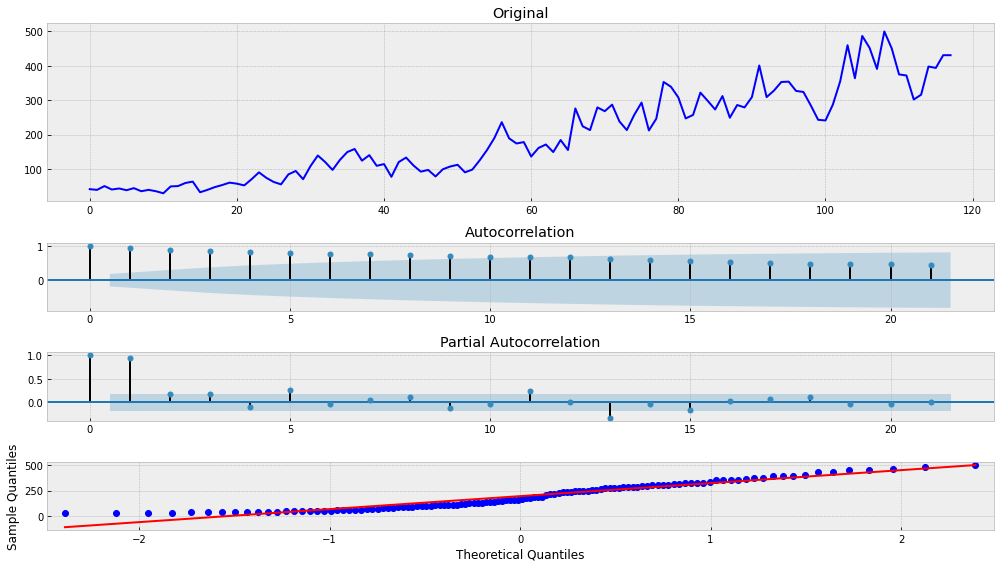

In [ ]:
series = pd.read_csv("/content/monthly-boston-armed-robberies-j.csv")['Count']
tsplot(series)


In [ ]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(7):
        for d in range(7):
            for j in range(7):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl


In [ ]:
aic, order, mdl = _get_best_model(series)

aic: 1182.68064 | order: (0, 2, 5)


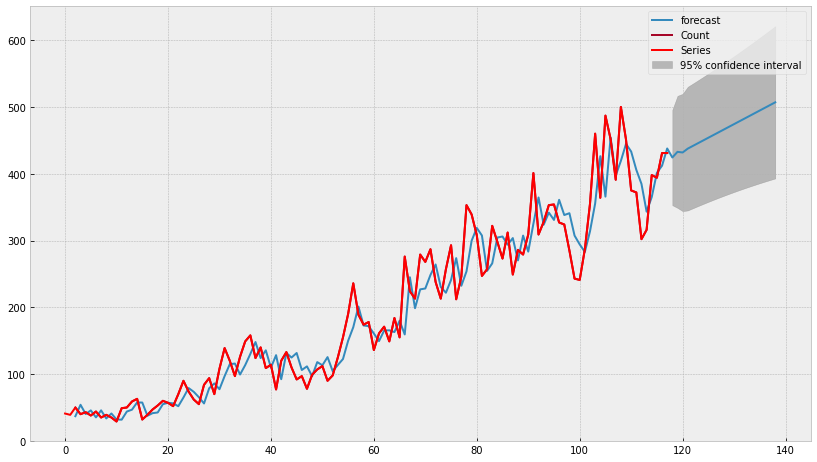

In [ ]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    mdl.plot_predict(2, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()



In [ ]:
series = boxcox(series, 0)
series = series[1:] - series[:-1]
series = series[12:] - series[:-12]


Results of Dickey-Fuller Test:
Test Statistic                 -3.938974
p-value                         0.001766
#Lags Used                     13.000000
Number of Observations Used    90.000000
Critical Value (1%)            -3.505190
Critical Value (5%)            -2.894232
Critical Value (10%)           -2.584210
dtype: float64


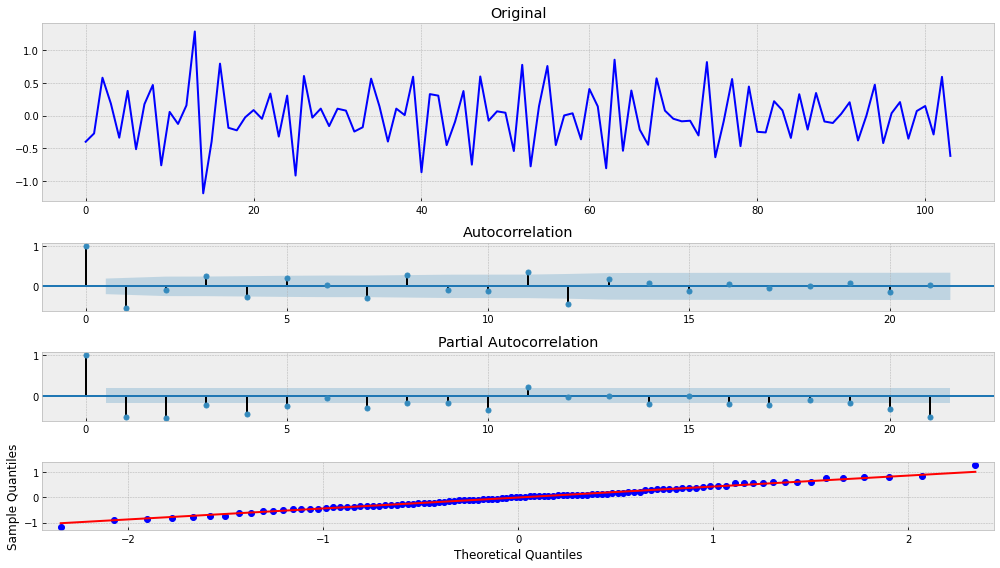

In [ ]:
series = np.diff(series, 1)
tsplot(series)

In [ ]:
order

(0, 2, 5)

In [ ]:
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     64,   Neg. LLF: 60.523993864857445
Iteration:     10,   Func. Count:    122,   Neg. LLF: 59.30133125888193
Iteration:     15,   Func. Count:    177,   Neg. LLF: 59.10560691549563
Iteration:     20,   Func. Count:    232,   Neg. LLF: 58.94356769542026
Optimization terminated successfully    (Exit mode 0)
            Current function value: 58.92424792571422
            Iterations: 24
            Function evaluations: 286
            Gradient evaluations: 24
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -58.9242
Distribution:      Standardized Student's t   AIC:                           137.848
Method:                  Maximum Likelihood   BIC:                          

In [ ]:
forecast = res.forecast(horizon=5)

In [ ]:
series.shape

(104,)

In [ ]:
series[-5:]

array([ 0.07083224,  0.1474443 , -0.28728401,  0.5930396 , -0.61494006])

In [ ]:
forecast.residual_variance

,h.1,h.2,h.3,h.4,h.5
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
99,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN
101,NaN,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN,NaN


Results of Dickey-Fuller Test:
Test Statistic                 -3.938974
p-value                         0.001766
#Lags Used                     13.000000
Number of Observations Used    90.000000
Critical Value (1%)            -3.505190
Critical Value (5%)            -2.894232
Critical Value (10%)           -2.584210
dtype: float64


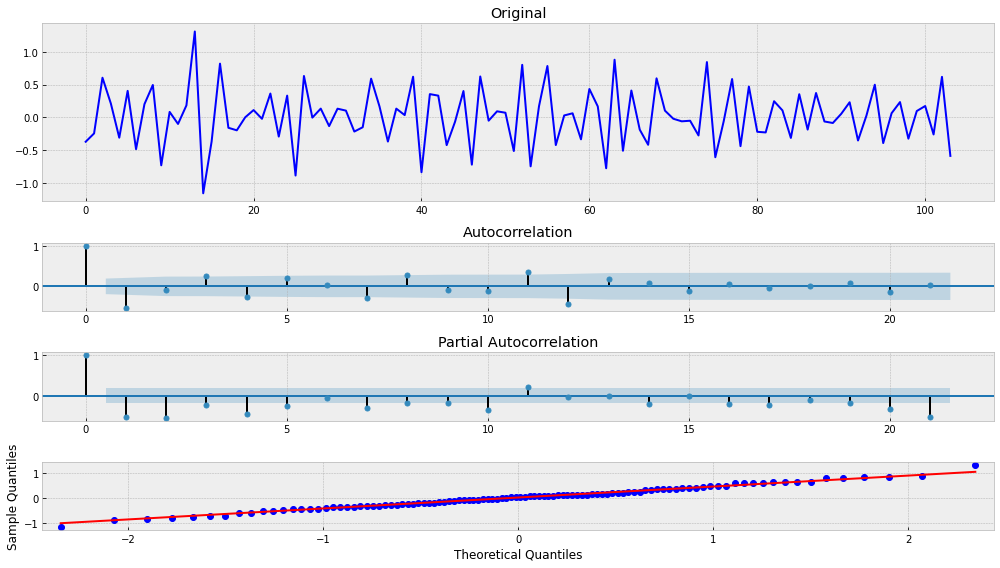

In [ ]:
tsplot(res.resid)